Importing required libraries

In [1]:
from Tumor_Classifier_Utils import *

Loading in the data

In [2]:
train, train_y, val, val_y, test, test_y, N, num_classes = load_data(64)

Checking Data

Visualisartion of data

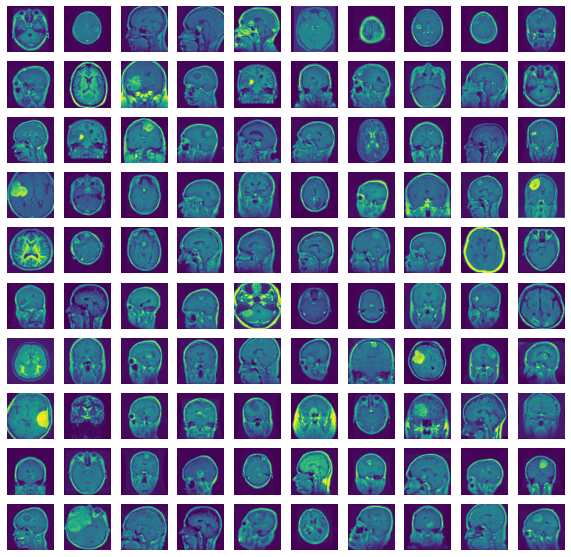

In [3]:
fig = plt.figure(figsize=[10, 10])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(train[i,:,:,0])
    ax.axis('off')    

### Network Architecture

In [4]:
num_epochs = 30 # how many training epochs we are doing

# build model function
def build_model(num_classes, output_activation=None):
    # Input in an image shape
    inputs = keras.Input(shape=(N, N, 1, ), name='img')
    
    # run pairs of conv layers, all 3s3 kernels
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(inputs) # consider using alternate activation
    x = layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation=None)(x)
    # batch normalisation, before the non-linearity
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    # spatial dropout, this will drop whole kernels, i.e. 20% of our 3x3 filters will be dropped out rather
    # than dropping out 20% of the invidual pixels
    x = layers.SpatialDropout2D(0.2)(x)
    # max pooling, 2x2, which will downsample the image
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # rinse and repeat with 2D convs, batch norm, dropout and max pool
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
    x = layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    # final conv2d, batch norm and spatial dropout
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x) # consider using alternate activation
    x = layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.SpatialDropout2D(0.2)(x)

    # flatten layer
    x = layers.Flatten()(x)
    
    # Neuron setup
    x = layers.Dense(256, activation='relu')(x) # consider using alternate activation
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x) # consider using alternate activation
    #x = layers.Dense(4, activation='softmax')(x)
    
    # the output
    outputs = layers.Dense(num_classes, activation=output_activation)(x)

    # build the model, and print a summary
    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='tumor_classifier_cnn_model')
    
    return model_cnn

In [5]:
model_cnn = build_model(4)
model_cnn.summary()

Model: "tumor_classifier_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 64, 64, 16)        0         
                                                                 
 spatial_dropout2d (SpatialD  (None, 64, 64, 16)       0         
 ropout2D)                              

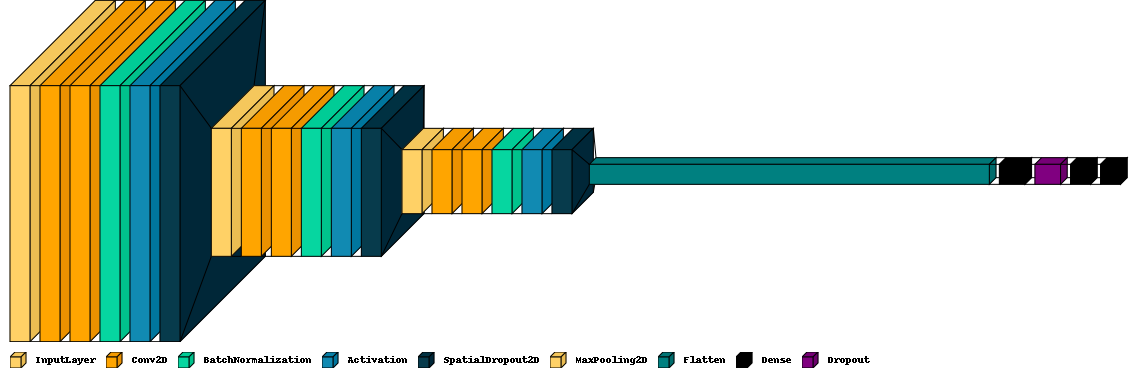

In [6]:
cmp = defaultdict(dict)
cmp[layers.Conv2D]['fill'] = 'orange'
cmp[layers.MaxPooling2D]['filal'] = 'red'
cmp[layers.Dense]['fill'] = 'black'
cmp[layers.Flatten]['fill'] = 'teal'
cmp[layers.Dropout]['fill'] = 'purple'
vk.layered_view(model_cnn, legend=True, color_map=cmp)

Training the model

In [7]:
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
classWeights = class_weights()
model_train_start_time = time.time()
history = model_cnn.fit(train, train_y,
                        batch_size=128,
                        epochs=100,
                        class_weight=classWeights,
                        validation_data=(val, val_y))
model_train_time = time.time() - model_train_start_time

Epoch 1/100
20/20 [==============================] - 11s 68ms/step - loss: 3.5764 - accuracy: 0.3339 - val_loss: 1.3846 - val_accuracy: 0.2857
Epoch 2/100
20/20 [==============================] - 0s 25ms/step - loss: 1.3744 - accuracy: 0.4812 - val_loss: 1.3703 - val_accuracy: 0.4429
Epoch 3/100
20/20 [==============================] - 1s 27ms/step - loss: 1.1901 - accuracy: 0.5314 - val_loss: 1.4042 - val_accuracy: 0.1429
Epoch 4/100
20/20 [==============================] - 0s 25ms/step - loss: 1.0587 - accuracy: 0.5882 - val_loss: 1.4500 - val_accuracy: 0.1429
Epoch 5/100
20/20 [==============================] - 0s 25ms/step - loss: 0.9964 - accuracy: 0.5992 - val_loss: 1.5179 - val_accuracy: 0.1429
Epoch 6/100
20/20 [==============================] - 0s 24ms/step - loss: 0.9718 - accuracy: 0.6024 - val_loss: 1.4882 - val_accuracy: 0.1429
Epoch 7/100
20/20 [==============================] - 0s 25ms/step - loss: 0.9285 - accuracy: 0.6294 - val_loss: 1.6664 - val_accuracy: 0.1429
Epoch

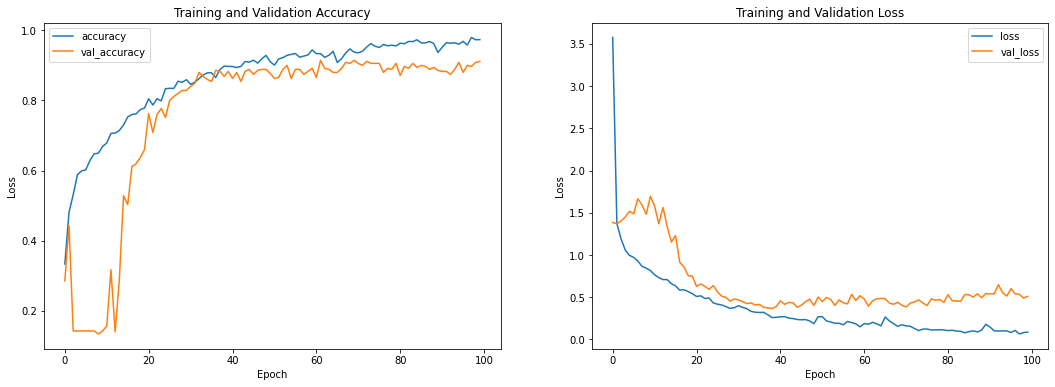

In [8]:
plot_loss(history)

### Model Evaluation

              precision    recall  f1-score   support

           0       0.47      0.88      0.61         8
           1       0.93      0.78      0.85       102
           2       0.89      0.95      0.92       127
           3       1.00      1.00      1.00        46

    accuracy                           0.90       283
   macro avg       0.82      0.90      0.84       283
weighted avg       0.91      0.90      0.90       283



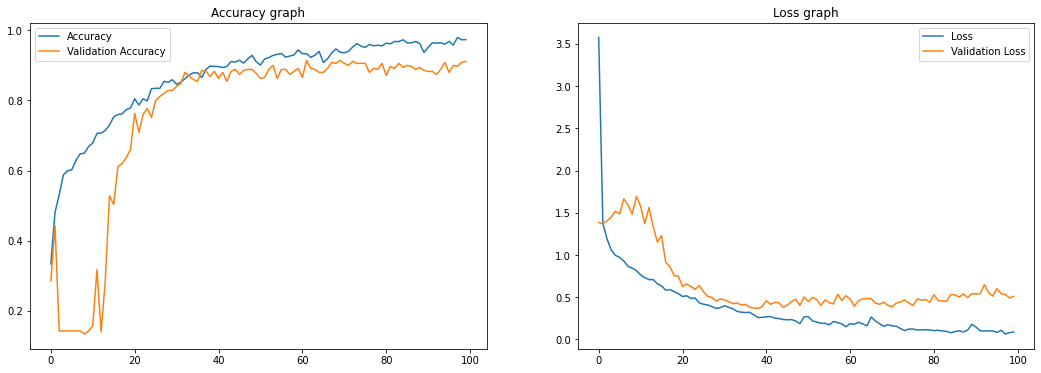

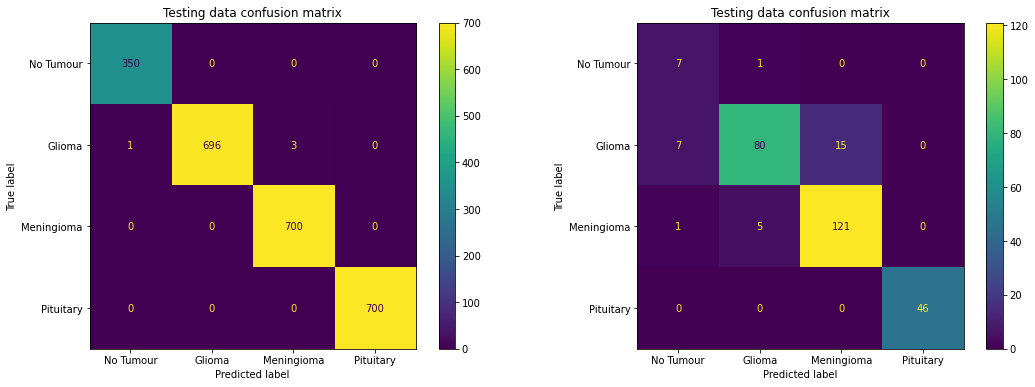

In [9]:
def eval_model(model, history, x_train, y_train, x_test, y_test):

    fig = plt.figure(figsize=[18, 6])    

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history['accuracy'], label='Accuracy')
    ax.plot(history['val_accuracy'], label='Validation Accuracy')
    ax.legend()
    ax.set_title('Accuracy graph')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history['loss'], label='Loss')
    ax.plot(history['val_loss'], label='Validation Loss')
    ax.legend()
    ax.set_title('Loss graph')

    pred = model.predict(x_train);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)

    fig = plt.figure(figsize=[18, 6]) 

    ax = fig.add_subplot(1, 2, 1)
    labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
    c = ConfusionMatrixDisplay(cm, display_labels=labels)
    
    c.plot(ax = ax)
    ax.set_title('Testing data confusion matrix')
    
    inference_start_time = time.time()
    pred = model.predict(x_test);
    inference_time = time.time() - inference_start_time
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)

    ax = fig.add_subplot(1, 2, 2)
    labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
    c = ConfusionMatrixDisplay(cm, display_labels=labels)
    
    c.plot(ax = ax)
    ax.set_title('Testing data confusion matrix')
    
    print(classification_report(y_test, indexes))
    return inference_time

inference_time = eval_model(model_cnn, history.history, train, train_y, test, test_y)

(283, 4)


c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\61424\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


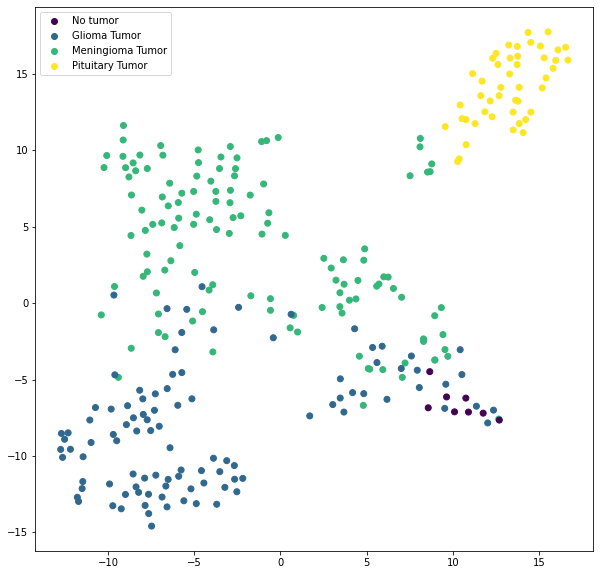

In [10]:
pred = model_cnn.predict(test);
print(pred.shape)
tsne_embeddings = TSNE(random_state=4).fit_transform(pred)
labels = ['No tumor', 'Glioma Tumor', 'Meningioma Tumor', 'Pituitary Tumor']
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
scatter = ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = test_y.flatten());
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, labels)
plt.show()

[ 15   8  86 102 136 127  46  46]


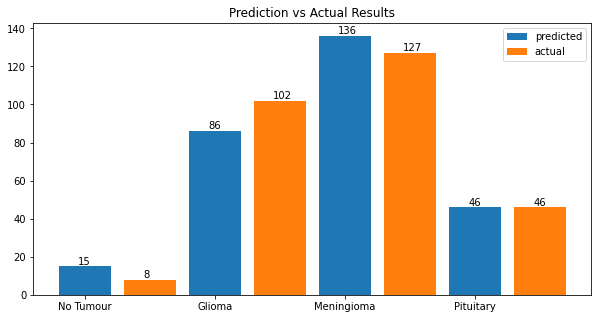

In [11]:
pred = model_cnn.predict(test);
indexes = tf.argmax(pred, axis=1)

test_thing = test_y[:] + 0.5

all_counts = []
for i in range(len(indexes)):
    all_counts.append(indexes[i])
    all_counts.append(test_thing[i][0])

labels_all, count_all = np.unique(all_counts, return_counts=True)
print(count_all)

fig = plt.figure(figsize=[10, 5])
ax = fig.subplots()

labels, counts = np.unique(indexes, return_counts=True)
labels = ['No Tumour', 'Glioma', 'Meningioma', 'Pituitary']
ax.set_title('Prediction vs Actual Results')
plt.bar(labels, counts, align='center', width = 0.4)
plt.gca().set_xticks(labels)
labels, counts = np.unique(test_thing, return_counts=True)
plt.bar(labels, counts, align='center', width = 0.4)
ax.legend(['predicted', 'actual'])

x = [0,0.5,1,1.5,2,2.5,3,3.5]

for i in range(len(count_all)):
    ax.text(x[i]-0.05, count_all[i] + 1, str(count_all[i]))
plt.show()

In [12]:
# runtimes
print(model_train_time)
print(inference_time)

56.43679904937744
0.15350103378295898


: 